In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
import os
from PIL import Image
from tqdm import tqdm

# Update this to your actual folder
data_dir = "/content/drive/MyDrive/food_vision_dataset"

# Target image size
IMG_SIZE = (224, 224)


In [5]:
import os
import random
import shutil
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split

# Set parameters
data_dir = Path("/content/drive/MyDrive/food_vision_dataset")  # Replace with your actual dataset path
output_dir = Path("path/to/split_dataset")  # Where train/val/test will go
img_height = 224
img_width = 224
batch_size = 32
seed = 123

# Step 1: Get all image paths and labels
all_images = list(data_dir.rglob("*.jpg"))  # or *.png depending on your dataset
all_labels = [img.parent.name for img in all_images]

# Step 2: Split into train, val, test
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=seed)

val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=seed)

# Step 3: Copy files into train/val/test directories
def copy_files(images, labels, subset):
    for img, label in zip(images, labels):
        dest_dir = output_dir / subset / label
        dest_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(img, dest_dir / img.name)

copy_files(train_imgs, train_labels, "train")
copy_files(val_imgs, val_labels, "val")
copy_files(test_imgs, test_labels, "test")

# Step 4: Load datasets with image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    output_dir / "train",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=seed
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    output_dir / "val",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=seed
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    output_dir / "test",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=seed
)


Found 1612 files belonging to 10 classes.
Found 345 files belonging to 10 classes.
Found 346 files belonging to 10 classes.


In [6]:
# Naming the classes
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['akara', 'banga_soup', 'egusi_soup', 'jollof_rice', 'moi_moi', 'nkwobi', 'okpa', 'suya', 'tuwo', 'yam_porridge']


In [7]:
import os

def count_images_per_class(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))
            ])
            class_counts[class_name] = num_images

    # Print counts
    for class_name, count in sorted(class_counts.items()):
        print(f"{class_name}: {count} images")

# Run the count
count_images_per_class('/content/drive/MyDrive/food_vision_dataset')


akara: 265 images
banga_soup: 266 images
egusi_soup: 260 images
jollof_rice: 276 images
moi_moi: 244 images
nkwobi: 224 images
okpa: 250 images
suya: 229 images
tuwo: 245 images
yam_porridge: 243 images


In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras import Sequential


def to_categorical(image, label):
    num_classes = len(train_ds.class_names)
    return image, tf.one_hot(label, depth=num_classes)

train_dataset = train_ds.map(to_categorical)
val_dataset = val_ds.map(to_categorical)
test_dataset = test_ds.map(to_categorical)

# Augmentation pipeline (only for training set)
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

# Apply augmentation
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Set parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

# Get the number of classes from the training dataset
num_classes = len(train_ds.class_names)

# Load MobileNetV2 base
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # We'll fine-tune later

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Unfreeze base model
base_model.trainable = False

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Train (initial phase)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

# Save model
model.save("mobilenet_model.h5")

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.1552 - loss: 2.5372 - val_accuracy: 0.2841 - val_loss: 2.0936
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.2817 - loss: 2.0085 - val_accuracy: 0.3246 - val_loss: 1.9555
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.3725 - loss: 1.7709 - val_accuracy: 0.3565 - val_loss: 1.8999
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.4013 - loss: 1.7172 - val_accuracy: 0.3362 - val_loss: 1.9465
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.4215 - loss: 1.6054 - val_accuracy: 0.3391 - val_loss: 1.9410
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.4461 - loss: 1.5678 - val_accuracy: 0.3826 - val_loss: 1.8351
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.4400 - loss: 1.5900 - val_accuracy: 0.3710 - val_loss: 1.8282
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.4616 - loss: 1.5252 - val_accuracy: 0.4174 - val_

In [22]:
# Define the directory path
save_dir = '/content/drive/MyDrive/FoodHealth_pro/'

# Create the directory if it does not exist
os.makedirs(save_dir, exist_ok=True)

# Define the full file path
file_path = os.path.join(save_dir, 'mobilenet_model.h5.keras')

# Save the model
model.save(file_path)

In [12]:
# Evaluating the model performance

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print("Training Accuracy:", acc[-1])
print("Validation Accuracy:", val_acc[-1])
print("Training Loss:", loss[-1])
print("Validation Loss:", val_loss[-1])

Training Accuracy: 0.5440446734428406
Validation Accuracy: 0.3942028880119324
Training Loss: 1.3218677043914795
Validation Loss: 1.8993401527404785


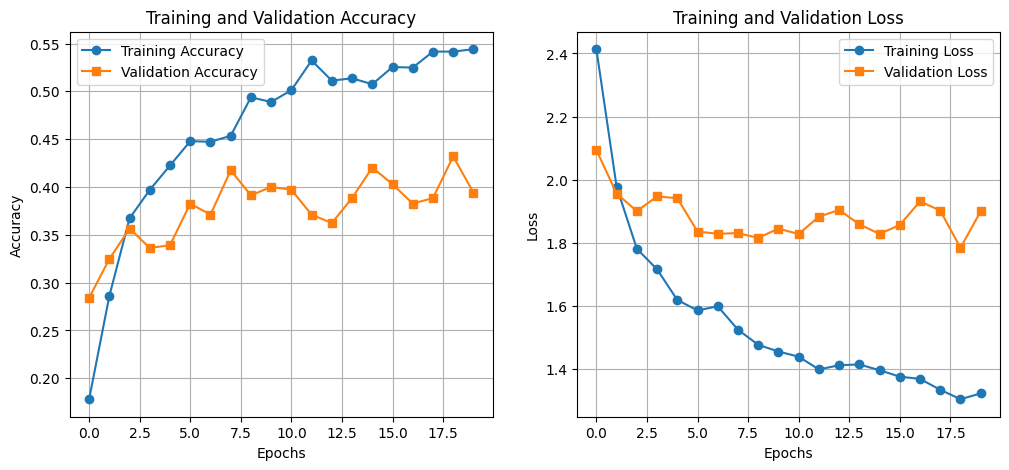

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy', marker='o')
plt.plot(range(20), val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss', marker='o')
plt.plot(range(20), val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()

plt.show()


In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3768 - loss: 1.8250
Test Loss: 1.9018223285675049
Test Accuracy: 0.34971097111701965


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.25      0.35        36
           1       0.04      0.03      0.03        33
           2       0.21      0.86      0.33        36
           3       0.50      0.26      0.34        39
           4       0.75      0.09      0.16        34
           5       0.48      0.47      0.48        32
           6       0.52      0.36      0.43        36
           7       0.56      0.48      0.52        31
           8       0.62      0.60      0.61        35
           9       0.21      0.09      0

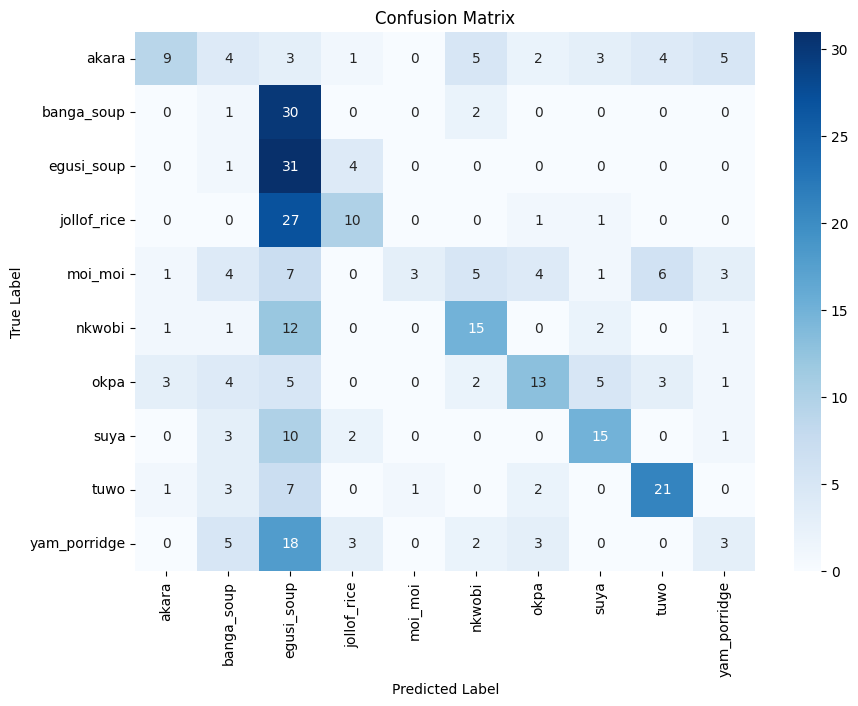

In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels from the test set
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=-1))  # Convert predictions to labels

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
